In [1]:
import pathlib as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import simple_soil

Conversion factors

In [2]:
in2m = 1.0 / (12.0 * 3.28081)
acre2sqm = 4046.86

hru_1 parameters

In [3]:
area = 2715.617356 * acre2sqm
factor = 10000.0
max_vertical_rate = 0.05  # 0.08239 * in2m * factor
horizontal_vertical_ratio = 1.0  # 0.01 * in2m * factor / max_vertical_rate

In [4]:
theta_sat = 0.2
theta_fc = 0.1
theta_wp = 0.01

In [5]:
thickness = 3.0  # 0.659252 * in2m / theta_fc
thickness

3.0

Forcing data

In [6]:
tag = " 2"

In [7]:
# rainfall
rain = pd.read_csv(pl.Path("data/hru_1_rain.csv"), index_col=0)
rain["ppt m/day"] = rain[tag] * in2m
rain = rain.drop(tag, axis=1)
rain.columns

Index(['ppt m/day'], dtype='object')

In [8]:
# canopy et
canopy_et = pd.read_csv(pl.Path("data/hru_1_intcpevap.csv"), index_col=0)

In [9]:
# potential
pet = pd.read_csv(pl.Path("data/hru_1_potet.csv"), index_col=0)

<Axes: xlabel='Date'>

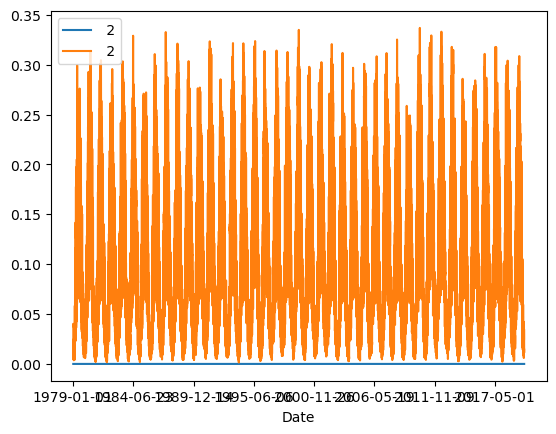

In [10]:
ax = canopy_et.plot(label="canopy")
pet.plot(ax=ax, label="pet")

In [11]:
# soil pet
pet["pet m/day"] = (pet[tag] - canopy_et[tag]) * in2m
pet = pet.drop(tag, axis=1)
pet.columns

Index(['pet m/day'], dtype='object')

<Axes: xlabel='Date'>

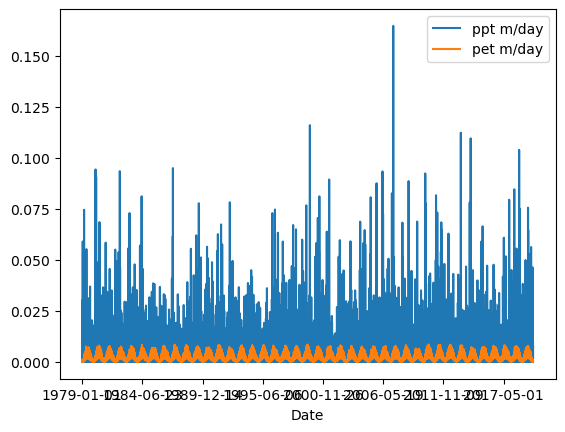

In [12]:
ax = rain.plot()
pet.plot(ax=ax, label="pet")

Control volume

In [13]:
cv = simple_soil.base.ControlVolume(
    area=area,
    thickness=thickness,
    max_vertical_rate=max_vertical_rate,
    horizontal_vertical_ratio=horizontal_vertical_ratio,
    theta0=0.1,
    theta_wp=theta_wp,
    theta_fc=theta_fc,
    theta_sat=theta_sat,
)

In [14]:
cv

aet_volume=None
area=10989723.25330216
converged=False
delta_t=None
delta_theta=0.0001
discharge_thickness=0.1
error=None
horizontal_vertical_ratio=1.0
inflow_rate=None
inflow_volume=None
iterations=None
lateral_volume=None
max_horizontal_rate=0.05
max_iterations=100
max_vertical_rate=0.05
output_dict={'total_time': [], 'iterations': [], 'theta': [], 'volume_L3/T': [], 'rejected_inflow_L3/T': [], 'inflow_L3/T': [], 'surface_L3/T': [], 'aet_L3/T': [], 'lateral_L3/T': [], 'recharge_L3/T': [], 'storage_change_L3/T': [], 'residual_L3/T': []}
pet_fraction=0.15
pet_rate=None
recharge_volume=None
smoothing_omega=1e-06
storage_volume_change=None
surface_volume=None
theta=0.1
theta0=0.1
theta_discharge=0.19333333333333333
theta_fc=0.1
theta_pet_max=0.0385
theta_sat=0.2
theta_wp=0.01
thickness=3.0
total_time=0.0
volume=3296916.9759906484
volume0=3296916.9759906484
volume_max=6593833.951981297

In [15]:
for inflow, pet_rate in zip(rain["ppt m/day"][0:366], pet["pet m/day"][0:366]):
    cv.update(inflow_rate=inflow, pet_rate=pet_rate * 0.5)

In [16]:
df = cv.get_dataframe(normalize=True)

In [17]:
df

,iterations,theta,volume_L/T,rejected_inflow_L/T,inflow_L/T,surface_L/T,aet_L/T,lateral_L/T,recharge_L/T,storage_change_L/T,residual_L/T
total_time,,,,,,,,,,,
1.0,3,0.100639,1.431144,0.0,0.010619,-0.0,-0.000481,-0.000024,-0.000024,-0.010091,-1.522759e-16
2.0,3,0.101929,1.451507,0.0,0.021027,-0.0,-0.000511,-0.000076,-0.000076,-0.020364,-2.123918e-15
3.0,3,0.101976,1.452256,0.0,0.001062,-0.0,-0.000157,-0.000078,-0.000078,-0.000749,-1.198345e-16
4.0,3,0.101962,1.452035,0.0,0.000000,-0.0,-0.000066,-0.000077,-0.000077,0.000221,8.520003e-17
5.0,3,0.101948,1.451805,0.0,0.000000,-0.0,-0.000076,-0.000077,-0.000077,0.000230,2.900691e-17
...,...,...,...,...,...,...,...,...,...,...,...
362.0,3,0.113313,1.631251,0.0,0.000000,-0.0,-0.000283,-0.000789,-0.000789,0.001861,2.780691e-17
363.0,3,0.113191,1.629335,0.0,0.000000,-0.0,-0.000359,-0.000779,-0.000779,0.001916,-2.158346e-16
364.0,3,0.113072,1.627448,0.0,0.000000,-0.0,-0.000350,-0.000769,-0.000769,0.001887,6.289658e-18


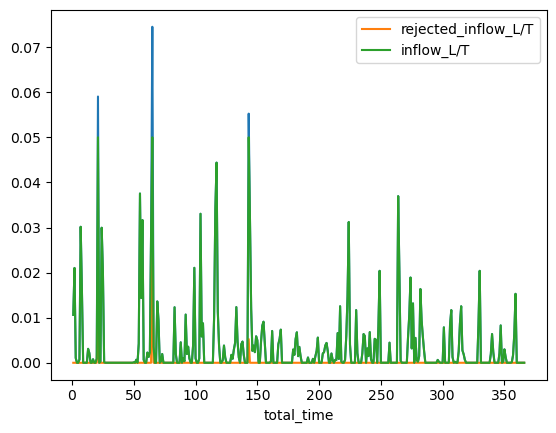

In [18]:
ax = (df["rejected_inflow_L/T"] + df["inflow_L/T"]).plot()
df["rejected_inflow_L/T"].plot(ax=ax)
df["inflow_L/T"].plot(ax=ax)
ax.legend()

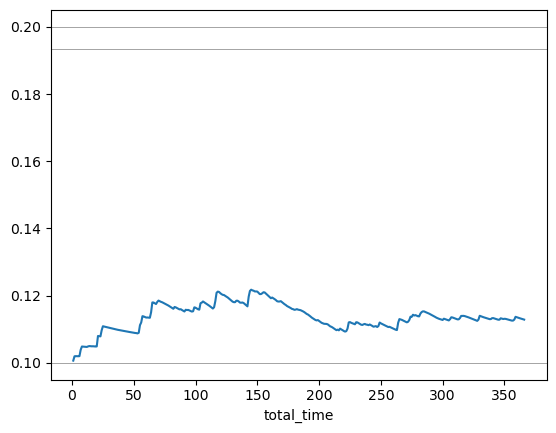

In [19]:
ax = df["theta"].plot()
ax.axhline(cv.theta_fc, lw=0.5, color="0.5")
ax.axhline(cv.theta_discharge, lw=0.5, color="0.5")
ax.axhline(cv.theta_sat, lw=0.5, color="0.5")

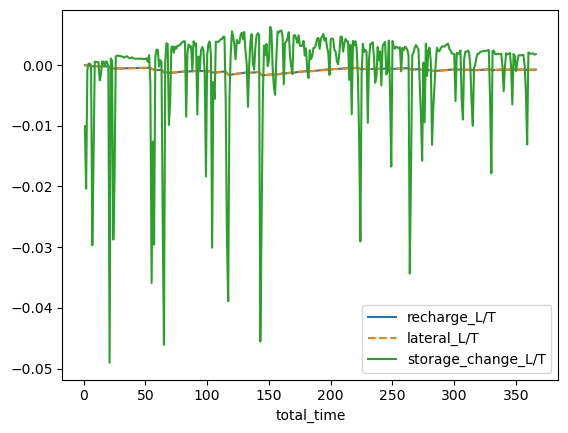

In [20]:
ax = df["recharge_L/T"].plot()
df["lateral_L/T"].plot(ax=ax, ls="--")
df["storage_change_L/T"].plot(ax=ax)
ax.legend()